In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir

import cv2 as cv
from PIL import Image

from p6_utils import display_thumbnails_from_df, preproc_image

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

pd.set_option('plotting.backend', 'plotly')
pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 100)


%reload_ext autoreload
%autoreload 2

# Récupération des données

## Catégories

In [2]:
df_desc = pd.read_csv('data/description_product.csv')

In [3]:
def separate_categ(s: str):
    to_return = s.replace('[', '').replace(']', '').replace('&', 'and').replace('"','')
    to_return = to_return.split('>>')
    for ind in range(len(to_return)):
        to_return[ind] = to_return[ind].strip()
    to_return = ','.join(to_return[:])
    to_return = to_return.lower()
    
    to_return = to_return.replace('&', 'and')
    return to_return

In [4]:
df_pict = df_desc[['image', 'product_category_tree']].copy(deep=True)

to_clean = df_desc.product_category_tree.apply(func=separate_categ)
main_categories = to_clean.apply(func=lambda x: x.split(',')[0])

df_pict.product_category_tree = main_categories
df_pict.rename(columns={'product_category_tree':'category', 'image':'name_image'}, inplace=True)
df_pict.set_index('name_image', inplace=True)
df_pict.head()

,category
name_image,
55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing
7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care
64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care
d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing
6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing


## Images

In [5]:
path = 'data/Images/'
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [6]:
# to silence the decompression bomb warning
Image.MAX_IMAGE_PIXELS = 1000000000  

dict_images = {}

# Je récupère toutes les images que je place dans un dictionnaire
for name in df_pict.index:
    dict_images[name] = np.array(Image.open(path+name))

In [7]:
to_join = pd.Series(data=dict_images.values(), index=dict_images.keys())
df_pict = df_pict.join(to_join.rename('image'))

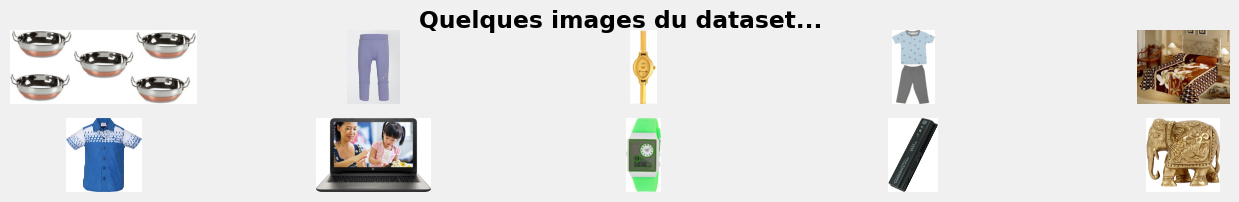

In [8]:
display_thumbnails_from_df(df_pict.image.sample(10), n_rows=2, title='Quelques images du dataset...')

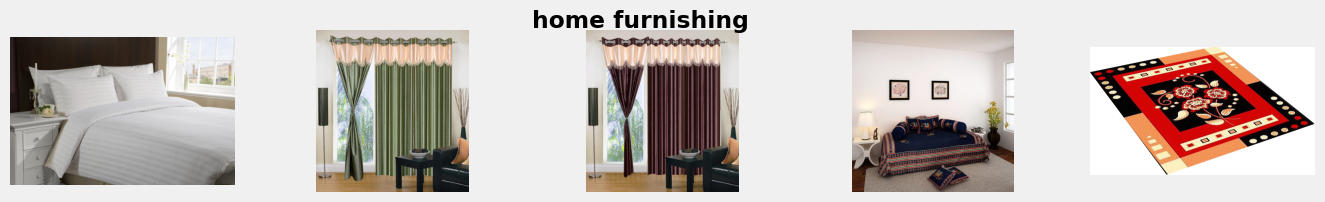

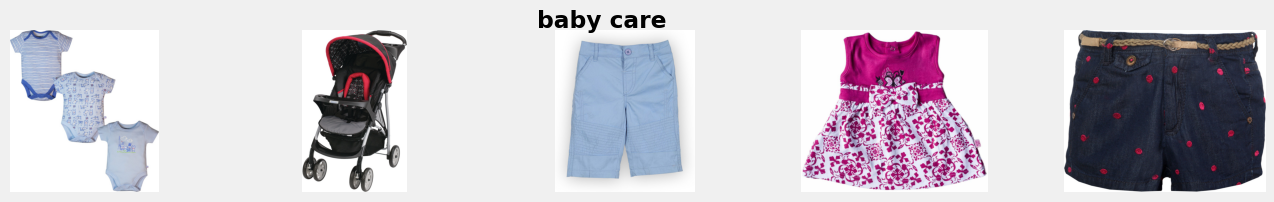

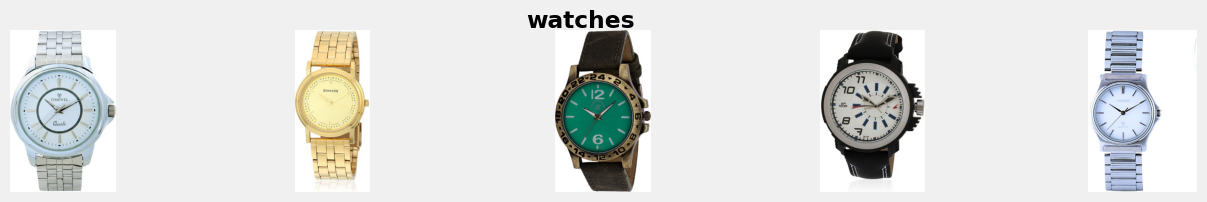

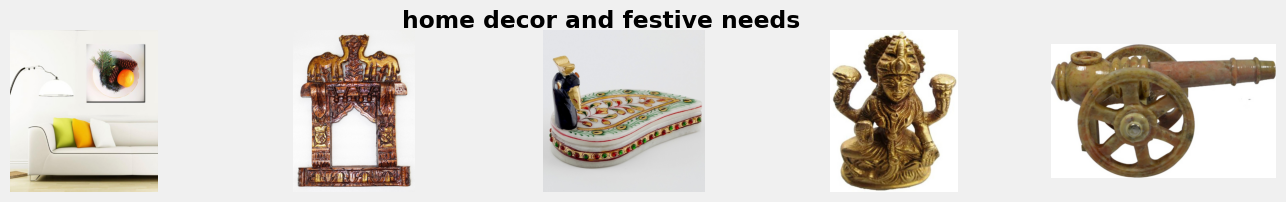

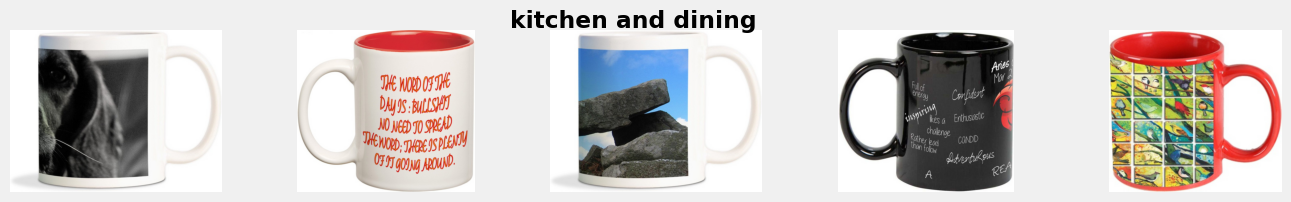

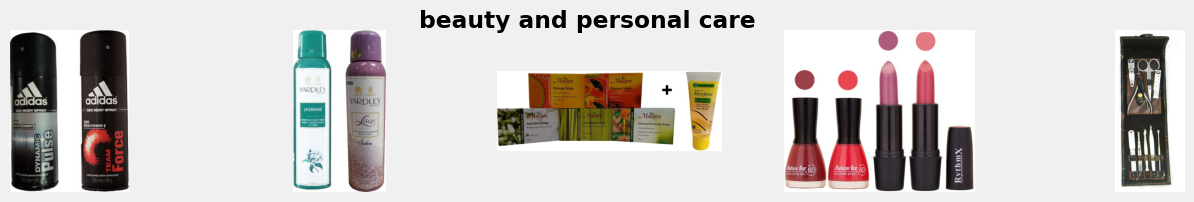

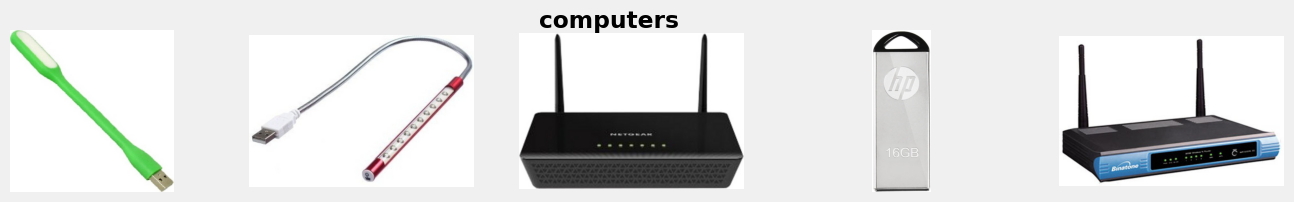

In [9]:
for categ in df_pict.category.unique():
    img_to_display= df_pict[df_pict.category == categ].image.sample(5)
    display_thumbnails_from_df(img_to_display, title=f'{categ}')

# Approche non-supervisée

## Prétraitements

In [12]:
no_preproc = [('convert_color', {'code': cv.COLOR_BGR2GRAY})
            ]

resized = [('convert_color', {'code': cv.COLOR_BGR2GRAY}),
         ('resize', {'interpolation': cv.INTER_AREA, 'dsize':(512, 512)}),
         ]

blur3 = [('convert_color', {'code': cv.COLOR_BGR2GRAY}),
         ('resize', {'interpolation': cv.INTER_AREA, 'dsize':(512, 512)}),
         ('gauss_bl', {'ksize': (3,3), 'sigmaX':1})
        ]


blur3_small = [('convert_color', {'code': cv.COLOR_BGR2GRAY}),
         ('resize', {'interpolation': cv.INTER_AREA, 'dsize':(256, 256)}),
         ('gauss_bl', {'ksize': (3,3), 'sigmaX':1})
        ]

blur3_equalize = [('convert_color', {'code': cv.COLOR_BGR2GRAY}),
                  ('resize', {'interpolation': cv.INTER_AREA, 'dsize':(512, 512)}),
                  ('gauss_bl', {'ksize': (3,3), 'sigmaX':1}),
                  ('equalize', {})
                  ]

blur3_equalize_small = [('convert_color', {'code': cv.COLOR_BGR2GRAY}),
                  ('resize', {'interpolation': cv.INTER_AREA, 'dsize':(256, 256)}),
                  ('gauss_bl', {'ksize': (3,3), 'sigmaX':1}),
                  ('equalize', {})
                  ]

In [13]:
%%time

imgs = df_pict.image

imgs_no_preproc = imgs.apply(lambda img : preproc_image(img, no_preproc))
imgs_resized = imgs.apply(lambda img : preproc_image(img, resized))
imgs_blur3 = imgs.apply(lambda img : preproc_image(img, blur3))
imgs_blur3_small = imgs.apply(lambda img : preproc_image(img, blur3_small))
imgs_blur3_equalize = imgs.apply(lambda img : preproc_image(img, blur3_equalize))
imgs_blur3_equalize_small = imgs.apply(lambda img : preproc_image(img, blur3_equalize_small))

list_preproc = {'no_preproc':imgs_no_preproc, 
                'resized_only': imgs_resized, 
                'blur3': imgs_blur3, 
                'blur3_small': imgs_blur3_small,
                'blur3_equalize': imgs_blur3_equalize, 
                'blur3_equalize_small': imgs_blur3_equalize_small}

Wall time: 16.8 s


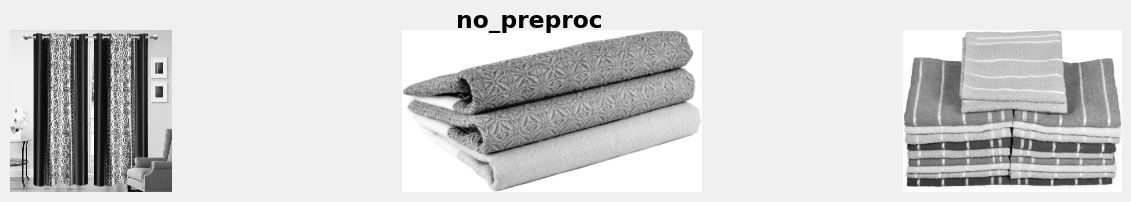

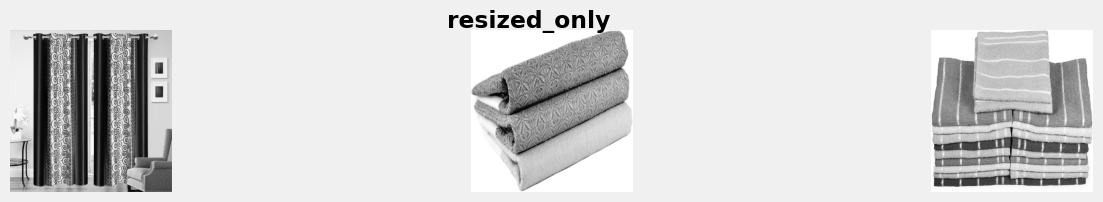

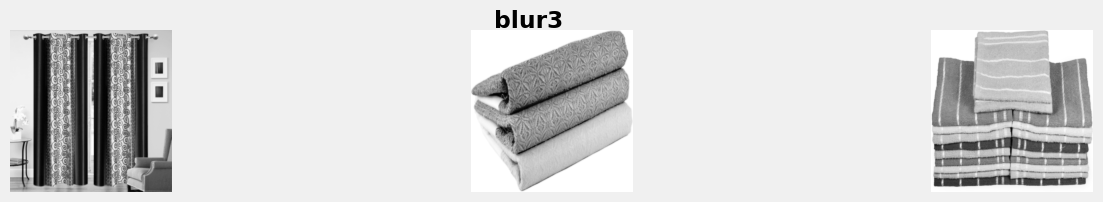

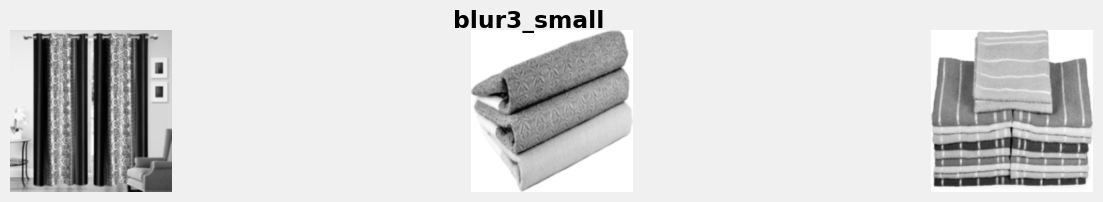

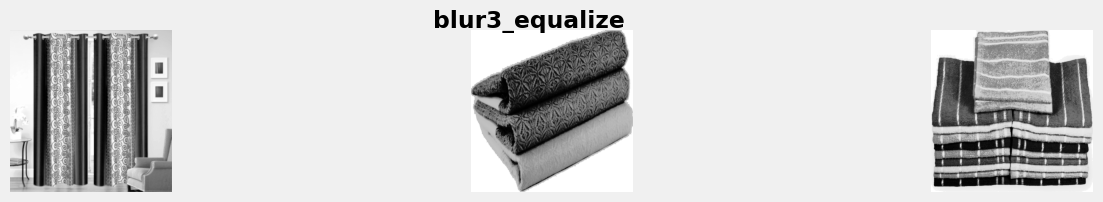

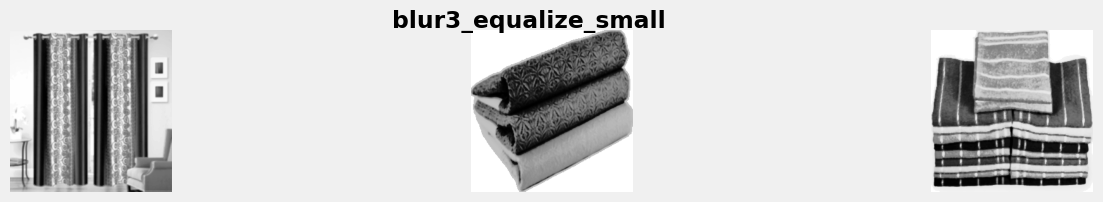

In [14]:
for name, imgs in list_preproc.items():
    img_to_display = imgs.iloc[0:3]
    display_thumbnails_from_df(img_to_display, title=f'{name}')

## Extraction de features avec SIFT

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn import manifold, decomposition

def create_descriptors(imgs, algorithm, orb=False, debug=False):
    keypoints = []
    algo = algorithm
    
    # On détecte les descripteurs et points clés pour chaque image de notre dataset
    for ind, img in enumerate(imgs):
        if ind%100 == 0 and debug: print(ind)
        if orb:
            kp = algo.detect(img,None)
            kp, desc = algo.compute(img, kp)
            desc = [np.zeros((32,))] if desc is None else desc # in case no descriptor
        else:    
            kp, desc = algo.detectAndCompute(img, None)
            desc = [np.zeros((128,))] if desc is None else desc # in case no descriptor
        keypoints.append(desc)
    
    keypoints_by_img = np.asarray(keypoints, dtype='object')
    keypoints_all    = np.concatenate(keypoints_by_img, axis=0)
    
    print("Nombre de descripteurs : ", keypoints_all.shape)
    
    return keypoints_by_img, keypoints_all

def create_visual_words(keypoints_all, model, nb_clusters=None):    
    k = int(round(np.sqrt(len(keypoints_all)),0)) if nb_clusters == None else nb_clusters
    
    print("Nombre de clusters estimés : ", k)
    print("Création de",k, "clusters de descripteurs ...")
    
    # Clustering
    kmeans = model(n_clusters=k, random_state=42)
    kmeans.fit(keypoints_all)
    
    return kmeans

def create_bag_of_visual_words(keypoints_by_img, kmeans, debug=False):
    # Creation of histograms (features)
    def build_histogram(kmeans, des, image_num):
        res = kmeans.predict(des)
        hist = np.zeros(len(kmeans.cluster_centers_))
        nb_des=len(des)
        if nb_des==0 : print("problème histogramme image  : ", image_num)
        for i in res:
            hist[i] += 1.0/nb_des
        return hist


    # Creation of a matrix of histograms
    hist_vectors=[]

    for i, image_desc in enumerate(keypoints_by_img) :
        if i%100 == 0 and debug: print(i)  
        hist = build_histogram(kmeans, np.array(image_desc, dtype=type(kmeans.cluster_centers_[0][0])), i) # On convertit le type du descripteur pour qu'il corresponde au kmeans
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)
    
    return im_features

def compute_ari_score(im_features, true_labels, n_components=0.95, debug=False):
    kmeans = KMeans(n_clusters=7, random_state=42)

    # Réduction de dimension - PCA
    if debug : print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=n_components)
    feat_pca= pca.fit_transform(im_features)
    if debug: print(f"Dimensions dataset après réduction PCA (n_components = {n_components}) : ", feat_pca.shape)

    # Centrage et Réduction
    std_scale = StandardScaler().fit(feat_pca)
    X_scaled = std_scale.transform(feat_pca)

    kmeans.fit(X_scaled)

    ari = adjusted_rand_score(true_labels, kmeans.labels_)
    
    return ari


def plot_tsne(im_features, labels, p=30):
    '''
    @param: p --> perplexity tsne
    '''
    print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=0.99)
    feat_pca= pca.fit_transform(im_features)
    print("Dimensions dataset après réduction PCA (99% variance expliquée) : ", feat_pca.shape)
    
    tsne = manifold.TSNE(n_components=2, perplexity=p, 
                     n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = labels.values
    
    plt.figure(figsize=(16,8))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
        palette=sns.color_palette('tab10', n_colors=len(labels.unique())), s=50, alpha=0.6)

    plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 

    plt.show()

### Sans preprocessing

#### BoVW

In [17]:
keypoints_by_img, keypoints_all = create_descriptors(imgs=imgs_no_preproc, algorithm=cv.xfeatures2d.SIFT_create(50), debug=True)
kmeans = create_visual_words(keypoints_all=keypoints_all, model=KMeans, nb_clusters=None)
im_features = create_bag_of_visual_words(keypoints_by_img=keypoints_by_img, kmeans=kmeans, debug=True)

0
100
200
300
400
500
600
700
800
900
1000
Nombre de descripteurs :  (52670, 128)
Nombre de clusters estimés :  229
Création de 229 clusters de descripteurs ...
0
100
200
300
400
500
600
700
800
900
1000


In [18]:
print('Exemple de descripteur d\'une image')
im_features[0]

Exemple de descripteur d'une image


array([0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.04,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.04, 0.  , 0.08, 0.  , 0.  , 0.02, 0.2 , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ,
       0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [19]:
bovw_df = pd.DataFrame(data=im_features, index=imgs_no_preproc.index).join(df_pict.category)
bovw_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,category
name_image,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7.jpg,0.00,0.0,0.00,0.00,0.06,0.0,0.00,0.00,0.0,0.0,0.04,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.04,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.02,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.02,0.00,0.00,0.18,0.04,0.00,0.0,home furnishing
7b72c92c2f6c40268628ec5f14c6d590.jpg,0.00,0.0,0.02,0.00,0.00,0.0,0.02,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.02,0.00,0.00,0.00,0.0,0.00,0.14,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.02,0.0,0.00,0.0,0.0,0.04,0.0,0.0,0.06,0.00,0.00,0.06,0.04,0.00,0.02,0.0,baby care
64d5d4a258243731dc7bbb1eef49ad74.jpg,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.04,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.04,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.0,baby care
d4684dcdc759dd9cdf41504698d737d8.jpg,0.00,0.0,0.00,0.00,0.04,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.02,0.1,0.02,0.04,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.0,home furnishing
6325b6870c54cd47be6ebfbffa620ec7.jpg,0.02,0.0,0.00,0.04,0.00,0.0,0.00,0.00,0.0,0.0,0.02,0.0,0.0,0.0,0.00,0.00,0.04,0.02,0.0,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.00,0.0,0.00,0.0,0.04,0.0,0.0,0.00,0.0,0.0,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.0,home furnishing


In [15]:
df_pict.head(1)

,category,image
name_image,,
55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,"[[[192, 184, 173], [192, 184, 173], [193, 185, 174], [193, 185, 174], [193, 185, 174], [192, 184..."


#### Analyse visuelle de la séparation

Dimensions dataset avant réduction PCA :  (1050, 229)
Dimensions dataset après réduction PCA (99% variance expliquée) :  (1050, 203)


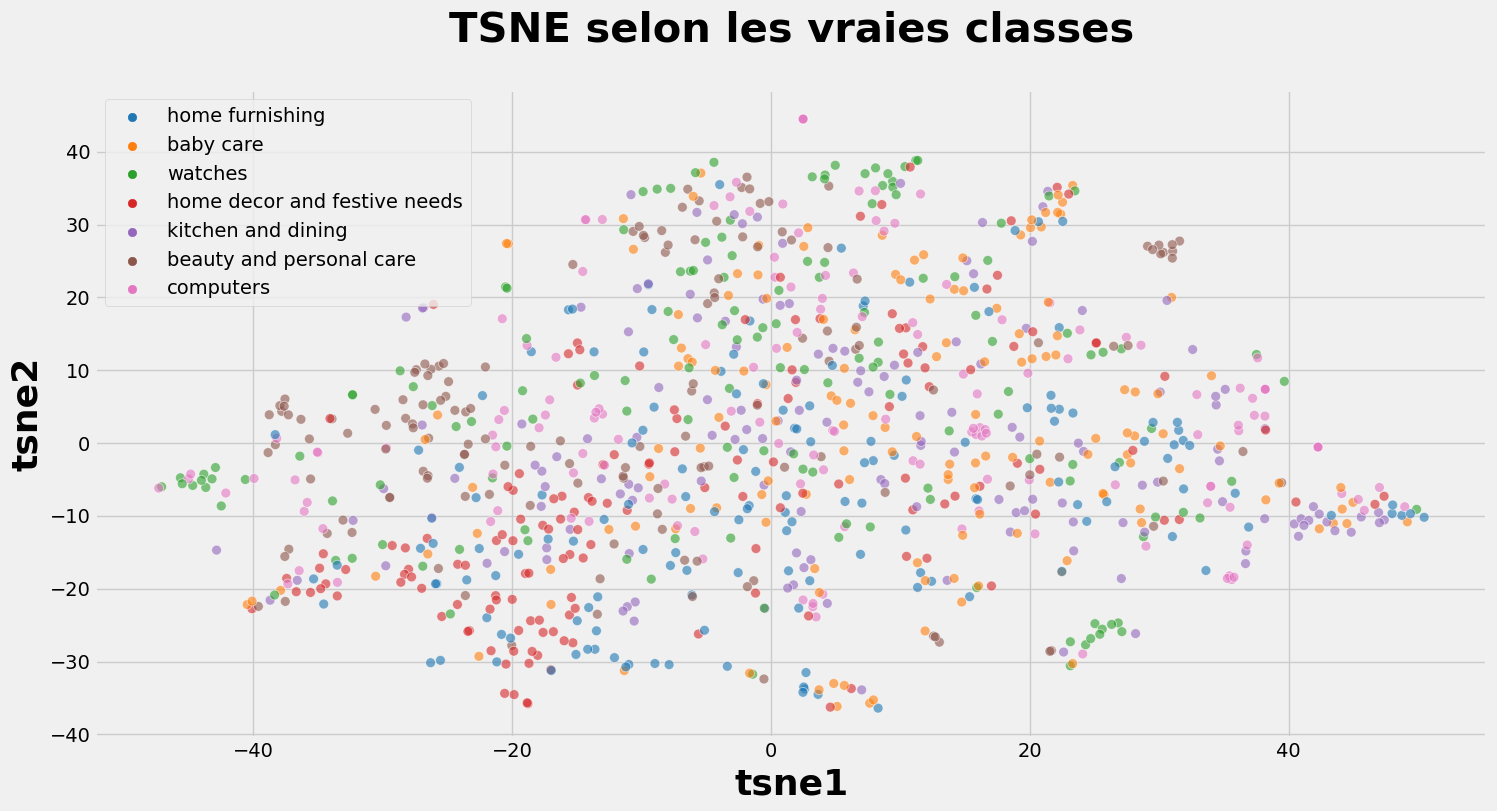

In [71]:
plot_tsne(im_features, bovw_df.category)

Certaines 'watches' semblent regroupées mais globalement l'ensemble à du bruit.

#### Analyse quantitative de la séparation

In [51]:
%%time
kmeans = KMeans(n_clusters=7, random_state=42)

# Réduction de dimension - PCA
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.95)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA (95% variance expliquée) : ", feat_pca.shape)

# Centrage et Réduction
std_scale = StandardScaler().fit(feat_pca)
X_scaled = std_scale.transform(feat_pca)

kmeans.fit(X_scaled)

adjusted_rand_score(bovw_df.category.values, kmeans.labels_)

Dimensions dataset avant réduction PCA :  (1050, 229)
Dimensions dataset après réduction PCA (95% variance expliquée) :  (1050, 152)
Wall time: 122 ms


0.001470031523308225

### Avec preprocessing

In [137]:
tmp = list_preproc.copy()
tmp.pop('no_preproc')

name_image
55b85ea15a1536d46b7190ad6fff8ce7.jpg    [[182, 182, 183, 183, 183, 182, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 183, 183, 184,...
7b72c92c2f6c40268628ec5f14c6d590.jpg    [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...
64d5d4a258243731dc7bbb1eef49ad74.jpg    [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...
d4684dcdc759dd9cdf41504698d737d8.jpg    [[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...
6325b6870c54cd47be6ebfbffa620ec7.jpg    [[97, 78, 64, 59, 67, 78, 81, 86, 76, 72, 54, 37, 34, 39, 54, 75, 102, 122, 144, 156, 160, 161, ...
                                                                                       ...                                                 
958f54f4c46b53c8a0a9b8167d9140bc.jpg    [[252, 254, 254, 254, 253, 254, 254, 253, 252, 252, 254, 255, 255, 254, 252, 253, 255, 255, 255,...
fd6cbcc22

In [138]:
%%time 

algorithm=cv.xfeatures2d.SIFT_create(50)
categ = df_pict.category

for name, imgs in tmp.items():
    print(f'---------- {name} ----------')
    print('--- Calcul des keypoints ---')
    keypoints_by_img, keypoints_all = create_descriptors(imgs=imgs, algorithm=algorithm)
    print('--- Création des visual words ---')
    kmeans = create_visual_words(keypoints_all=keypoints_all, model=KMeans, nb_clusters=None)
    print('--- Création des features ---')
    im_features = create_bag_of_visual_words(keypoints_by_img=keypoints_by_img, kmeans=kmeans)
    
    bovw_df = pd.DataFrame(data=im_features, index=imgs.index).join(categ)
    
    print(f'Score ARI ({name}): {compute_ari_score(im_features, bovw_df.category.values)}')
    print()

---------- resized_only ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (52346, 128)
--- Création des visual words ---
Nombre de clusters estimés :  229
Création de 229 clusters de descripteurs ...
--- Création des features ---
Dimensions dataset avant réduction PCA :  (1050, 229)
Dimensions dataset après réduction PCA (95% variance expliquée) :  (1050, 161)
Score ARI (resized_only): 0.006957276955499274

---------- blur3 ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (52171, 128)
--- Création des visual words ---
Nombre de clusters estimés :  228
Création de 228 clusters de descripteurs ...
--- Création des features ---
Dimensions dataset avant réduction PCA :  (1050, 228)
Dimensions dataset après réduction PCA (95% variance expliquée) :  (1050, 164)
Score ARI (blur3): 0.006058921807023648

---------- blur3_small ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (51306, 128)
--- Création des visual words ---
Nombre de clusters estim

## Extraction de features avec ORB

In [139]:
%%time 

algorithm=cv.ORB_create(50)
categ = df_pict.category

for name, imgs in list_preproc.items():
    print(f'---------- {name} ----------')
    print('--- Calcul des keypoints ---')
    keypoints_by_img, keypoints_all = create_descriptors(imgs=imgs, algorithm=algorithm, orb=True)
    print('--- Création des visual words ---')
    kmeans = create_visual_words(keypoints_all=keypoints_all, model=KMeans, nb_clusters=None)
    print('--- Création des features ---')
    im_features = create_bag_of_visual_words(keypoints_by_img=keypoints_by_img, kmeans=kmeans)
    
    bovw_df = pd.DataFrame(data=im_features, index=imgs.index).join(categ)
    
    print(f'Score ARI ({name}): {compute_ari_score(im_features, bovw_df.category.values)}')
    print()

---------- no_preproc ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (52063, 32)
--- Création des visual words ---
Nombre de clusters estimés :  228
Création de 228 clusters de descripteurs ...
--- Création des features ---
Dimensions dataset avant réduction PCA :  (1050, 228)
Dimensions dataset après réduction PCA (95% variance expliquée) :  (1050, 185)
Score ARI (no_preproc): -0.00015853608856720018

---------- resized_only ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (51939, 32)
--- Création des visual words ---
Nombre de clusters estimés :  228
Création de 228 clusters de descripteurs ...
--- Création des features ---
Dimensions dataset avant réduction PCA :  (1050, 228)
Dimensions dataset après réduction PCA (95% variance expliquée) :  (1050, 184)
Score ARI (resized_only): 0.0011166822487583764

---------- blur3 ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (51686, 32)
--- Création des visual words ---
Nombre de clusters 

## Extraction de features avec du transfer learning

In [12]:
from tensorflow.keras.applications import EfficientNetB0

In [13]:
model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

### Prétraitements

In [51]:
resized_256 =  [('resize', {'interpolation': cv.INTER_AREA, 'dsize':(256, 256)}),
              ]

resized_512 =  [('resize', {'interpolation': cv.INTER_AREA, 'dsize':(512, 512)}),
              ]

blur3_rgb =  [('resize', {'interpolation': cv.INTER_AREA, 'dsize':(256, 256)}),
               ('gauss_bl', {'ksize': (3,3), 'sigmaX':1})
              ]


imgs = df_pict.image

imgs_resized_256 = imgs.apply(lambda img : preproc_image(img, resized_256))
imgs_resized_512 = imgs.apply(lambda img : preproc_image(img, resized_512))
imgs_blur3_rgb = imgs.apply(lambda img : preproc_image(img, blur3_rgb))

### 256x256

In [17]:
%%time
features_list = []

for img in imgs_resized_256:
    im_feat = model(img).numpy()[0]
    features_list.append(im_feat)

Wall time: 1min 41s


Dimensions dataset avant réduction PCA :  (1050, 1280)
Dimensions dataset après réduction PCA (99% variance expliquée) :  (1050, 671)


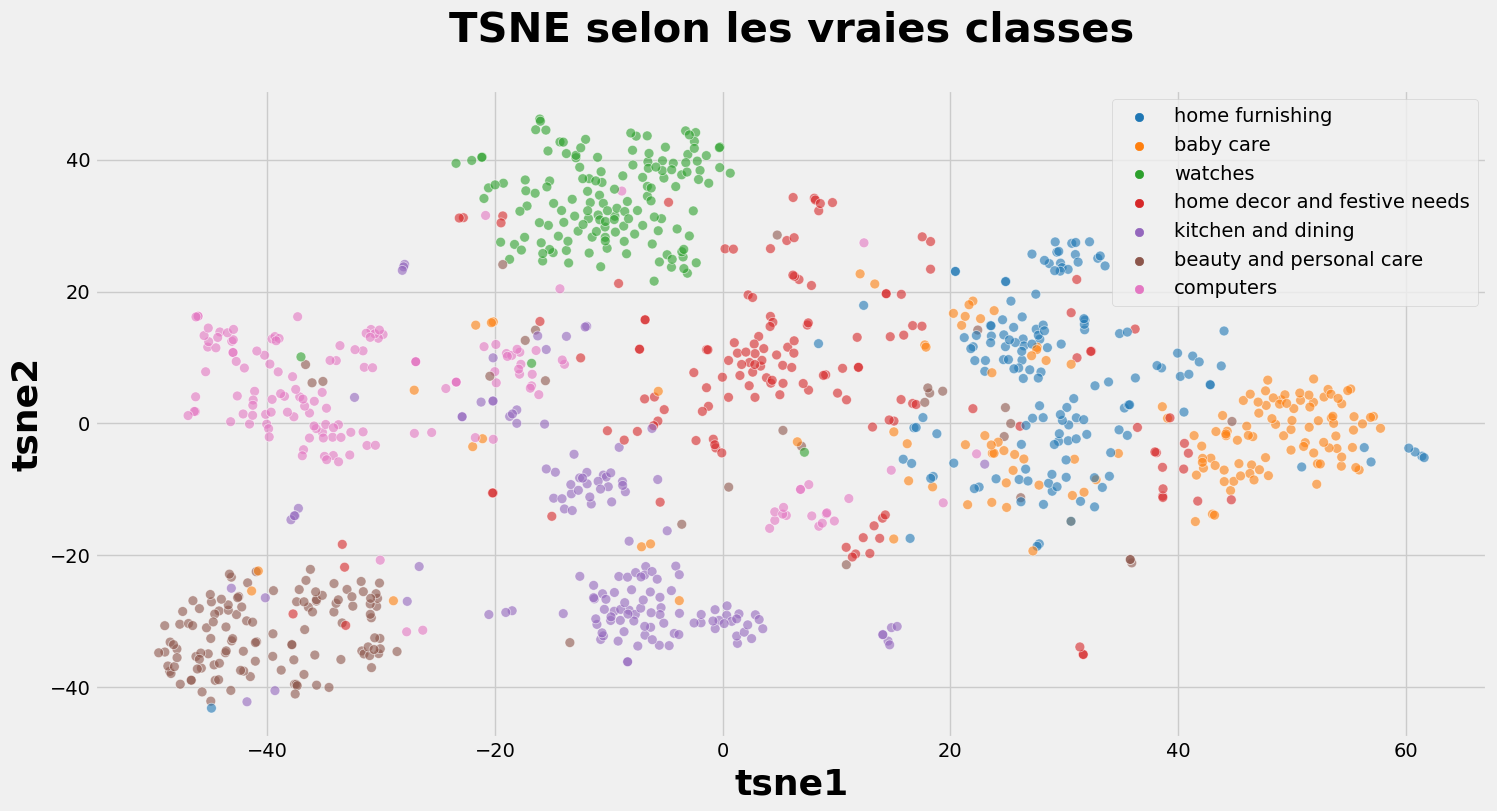

In [27]:
plot_tsne(np.array(features_list), df_pict.category)

In [49]:
for th in np.linspace(0.1,0.9,9):
    print(f'{th}: {compute_ari_score(np.array(features_list), df_pict.category, th)}')

0.1: 0.3620587820335951
0.2: 0.4785250274212298
0.30000000000000004: 0.5450344668077571
0.4: 0.5755691525796637
0.5: 0.22772652512287947
0.6: 0.1806245755958061
0.7000000000000001: 0.0946071817518619
0.8: 0.1560852520525824
0.9: 0.019914251067019818


### 512x512

Dimensions dataset avant réduction PCA :  (1050, 1280)
Dimensions dataset après réduction PCA (99% variance expliquée) :  (1050, 625)


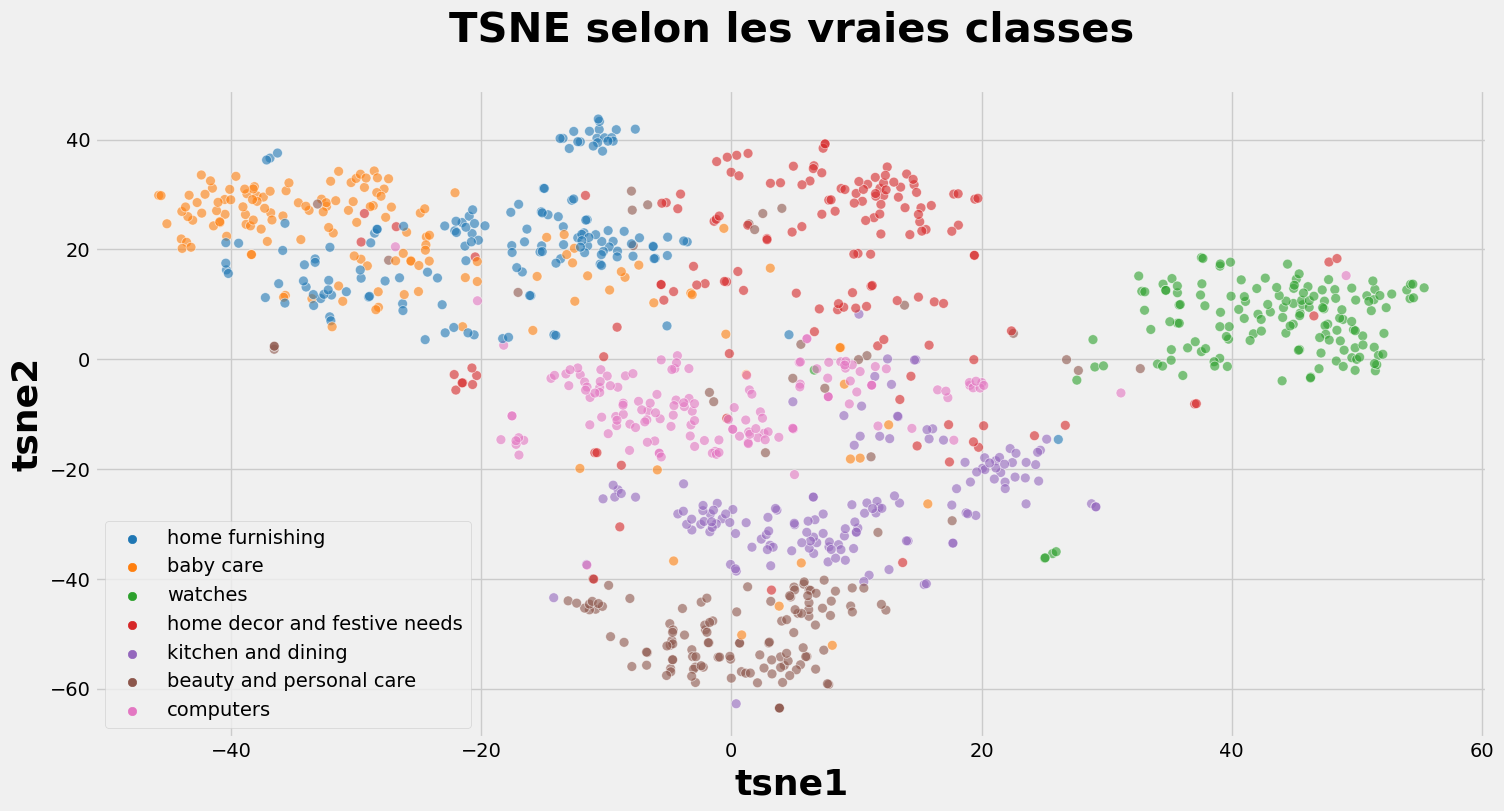

0.1: 0.3713816698073385
0.2: 0.4546100722112464
0.30000000000000004: 0.5235793315049522
0.4: 0.5460704524690457
0.5: 0.5005873821674159
0.6: 0.29186704530489305
0.7000000000000001: 0.19016523027659468
0.8: 0.1590035100967567
0.9: 0.038646903070235106
Wall time: 4min 33s


In [50]:
%%time
features_list = []

for img in imgs_resized_512:
    im_feat = model(img).numpy()[0]
    features_list.append(im_feat)

plot_tsne(np.array(features_list), df_pict.category)

for th in np.linspace(0.1,0.9,9):
    print(f'{th}: {compute_ari_score(np.array(features_list), df_pict.category, th)}')

### Avec filtre gaussien

Dimensions dataset avant réduction PCA :  (1050, 1280)
Dimensions dataset après réduction PCA (99% variance expliquée) :  (1050, 662)


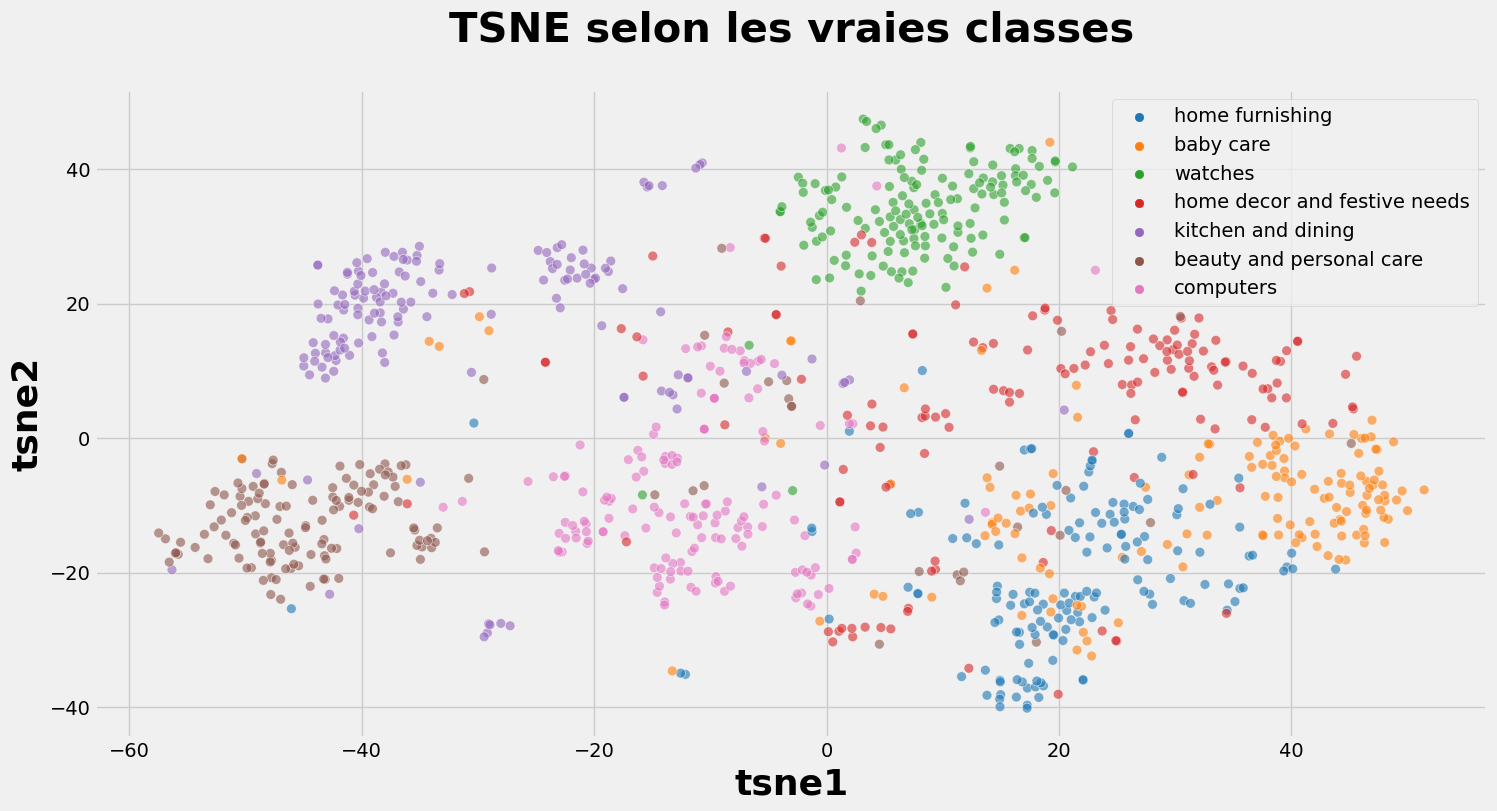

0.1: 0.30250141972162664
0.2: 0.47267849171713994
0.30000000000000004: 0.4733440640625566
0.4: 0.4007465061194825
0.5: 0.40461298637519344
0.6: 0.30834211133766176
0.7000000000000001: 0.16130343649773196
0.8: 0.08744363261499853
0.9: 0.02812956207618839
Wall time: 1min 54s


In [52]:
%%time
features_list = []

for img in imgs_blur3_rgb:
    im_feat = model(img).numpy()[0]
    features_list.append(im_feat)

plot_tsne(np.array(features_list), df_pict.category)

for th in np.linspace(0.1,0.9,9):
    print(f'{th}: {compute_ari_score(np.array(features_list), df_pict.category, th)}')

# Approche supervisée

## Random Forest

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### SIFT

In [16]:
df_pict.drop()

,category,image
name_image,,
55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,"[[[192, 184, 173], [192, 184, 173], [193, 185, 174], [193, 185, 174], [193, 185, 174], [192, 184..."
7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255..."
64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255..."
d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255..."
6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,"[[[99, 99, 91], [80, 80, 72], [67, 67, 57], [62, 62, 52], [72, 69, 60], [83, 80, 73], [85, 82, 7..."


In [37]:
%%time 

algorithm=cv.xfeatures2d.SIFT_create(50)
categ = df_pict.category
orb=False
debug = True

n_components=0.6
params = {'max_depth': range(5, 20, 3)}




for name, imgs in list_preproc.items():
    print(f'---------- {name} ----------')
    print('--- Calcul des keypoints ---')
    keypoints_by_img, keypoints_all = create_descriptors(imgs=imgs, algorithm=algorithm, orb=orb)
    print('--- Création des visual words ---')
    kmeans = create_visual_words(keypoints_all=keypoints_all, model=KMeans, nb_clusters=None)
    print('--- Création des features ---')
    im_features = create_bag_of_visual_words(keypoints_by_img=keypoints_by_img, kmeans=kmeans)
    
    bovw_df = pd.DataFrame(data=im_features, index=imgs.index).join(categ)
    
    train, test = train_test_split(bovw_df, test_size=0.2, stratify=bovw_df.category, random_state=42)
    
    X_train = train.drop('category', axis=1); y_train = train.category
    X_test = test.drop('category', axis=1); y_test = test.category
    
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    # Réduction de dimension - PCA
    if debug : print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=n_components)
    pca.fit_transform(X_train_std)
    X_train_pca = pca.transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)    
    if debug: print(f"Dimensions dataset après réduction PCA (n_components = {n_components}) : ", X_train_pca.shape)
    
    grid_search = GridSearchCV(RandomForestClassifier(n_estimators=200, random_state=0), params)
    grid_search.fit(X_train_pca, y_train)
    
    model = grid_search.best_estimator_
    
    print(f'Score ARI: {adjusted_rand_score(y_test, model.predict(X_test_pca))}')
    print(f'Accuracy: {accuracy_score(y_test, model.predict(X_test_pca))}')
    
    


---------- no_preproc ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (52670, 128)
--- Création des visual words ---
Nombre de clusters estimés :  229
Création de 229 clusters de descripteurs ...
--- Création des features ---
Dimensions dataset avant réduction PCA :  (1050, 229)
Dimensions dataset après réduction PCA (n_components = 0.6) :  (840, 60)
Score ARI: 0.09906131734489944
Accuracy: 0.3761904761904762
---------- resized_only ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (52346, 128)
--- Création des visual words ---
Nombre de clusters estimés :  229
Création de 229 clusters de descripteurs ...
--- Création des features ---
Dimensions dataset avant réduction PCA :  (1050, 229)
Dimensions dataset après réduction PCA (n_components = 0.6) :  (840, 64)
Score ARI: 0.07708571563620895
Accuracy: 0.37142857142857144
---------- blur3 ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (52171, 128)
--- Création des visual words ---
Nombr

### ORB

In [50]:
%%time 

algorithm=cv.ORB_create(50)
categ = df_pict.category
orb=True
debug = True

n_components=0.6
params = {'max_depth': range(5, 20, 3)}



for name, imgs in list_preproc.items():
    print(f'---------- {name} ----------')
    print('--- Calcul des keypoints ---')
    keypoints_by_img, keypoints_all = create_descriptors(imgs=imgs, algorithm=algorithm, orb=orb)
    print('--- Création des visual words ---')
    kmeans = create_visual_words(keypoints_all=keypoints_all, model=KMeans, nb_clusters=None)
    print('--- Création des features ---')
    im_features = create_bag_of_visual_words(keypoints_by_img=keypoints_by_img, kmeans=kmeans)
    
    bovw_df = pd.DataFrame(data=im_features, index=imgs.index).join(categ)
    
    train, test = train_test_split(bovw_df, test_size=0.2, stratify=bovw_df.category, random_state=42)
    
    X_train = train.drop('category', axis=1); y_train = train.category
    X_test = test.drop('category', axis=1); y_test = test.category
    
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    # Réduction de dimension - PCA
    if debug : print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=n_components)
    pca.fit_transform(X_train_std)
    X_train_pca = pca.transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)    
    if debug: print(f"Dimensions dataset après réduction PCA (n_components = {n_components}) : ", X_train_pca.shape)
    
    grid_search = GridSearchCV(RandomForestClassifier(n_estimators=200, random_state=0), params)
    grid_search.fit(X_train_pca, y_train)
    
    model = grid_search.best_estimator_
    
    print(f'Score ARI: {adjusted_rand_score(y_test, model.predict(X_test_pca))}')
    print(f'Accuracy: {accuracy_score(y_test, model.predict(X_test_pca))}')
    
    


---------- no_preproc ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (52063, 32)
--- Création des visual words ---
Nombre de clusters estimés :  228
Création de 228 clusters de descripteurs ...
--- Création des features ---
Dimensions dataset avant réduction PCA :  (1050, 228)
Dimensions dataset après réduction PCA (n_components = 0.6) :  (840, 77)
Score ARI: 0.030759721554386058
Accuracy: 0.3
---------- resized_only ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (51939, 32)
--- Création des visual words ---
Nombre de clusters estimés :  228
Création de 228 clusters de descripteurs ...
--- Création des features ---
Dimensions dataset avant réduction PCA :  (1050, 228)
Dimensions dataset après réduction PCA (n_components = 0.6) :  (840, 76)
Score ARI: 0.037140856158253556
Accuracy: 0.32857142857142857
---------- blur3 ----------
--- Calcul des keypoints ---
Nombre de descripteurs :  (51686, 32)
--- Création des visual words ---
Nombre de clusters es

### Transfer Learning

In [38]:
from tensorflow.keras.applications import EfficientNetB0



In [39]:
resized_256 =  [('resize', {'interpolation': cv.INTER_AREA, 'dsize':(256, 256)}),
              ]

resized_512 =  [('resize', {'interpolation': cv.INTER_AREA, 'dsize':(512, 512)}),
              ]

blur3_rgb =  [('resize', {'interpolation': cv.INTER_AREA, 'dsize':(256, 256)}),
               ('gauss_bl', {'ksize': (3,3), 'sigmaX':1})
              ]


imgs = df_pict.image

imgs_resized_256 = imgs.apply(lambda img : preproc_image(img, resized_256))
imgs_resized_512 = imgs.apply(lambda img : preproc_image(img, resized_512))
imgs_blur3_rgb = imgs.apply(lambda img : preproc_image(img, blur3_rgb))

#### 256x256

In [40]:
%%time
features_list = []
model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

for img in imgs_resized_256:
    im_feat = model(img).numpy()[0]
    features_list.append(im_feat)

Wall time: 1min 47s


In [49]:
categ = df_pict.category
orb=True
debug = True
n_components=0.6
params = {'max_depth': range(5, 20, 3)}

im_features = np.array(features_list)

bovw_df = pd.DataFrame(data=im_features, index=imgs.index).join(categ)

train, test = train_test_split(bovw_df, test_size=0.2, stratify=bovw_df.category, random_state=42)

X_train = train.drop('category', axis=1); y_train = train.category
X_test = test.drop('category', axis=1); y_test = test.category


scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Réduction de dimension - PCA
if debug : print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=n_components)
pca.fit_transform(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)    
if debug: print(f"Dimensions dataset après réduction PCA (n_components = {n_components}) : ", X_train_pca.shape)

grid_search = GridSearchCV(RandomForestClassifier(n_estimators=200, random_state=0), params)
grid_search.fit(X_train_pca, y_train)

model = grid_search.best_estimator_

print(f'Score ARI: {adjusted_rand_score(y_test, model.predict(X_test_pca))}')
print(f'Accuracy: {accuracy_score(y_test, model.predict(X_test_pca))}')

Dimensions dataset avant réduction PCA :  (1050, 1280)
Dimensions dataset après réduction PCA (n_components = 0.6) :  (840, 62)
Score ARI: 0.6548463717879064
Accuracy: 0.8333333333333334


#### 512x512

In [55]:
%%time
features_list = []
model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

for img in imgs_resized_512:
    im_feat = model(img).numpy()[0]
    features_list.append(im_feat)

categ = df_pict.category
orb=True
debug = True
n_components=0.6
params = {'max_depth': range(5, 20, 3)}

im_features = np.array(features_list)

bovw_df = pd.DataFrame(data=im_features, index=imgs.index).join(categ)

train, test = train_test_split(bovw_df, test_size=0.2, stratify=bovw_df.category, random_state=42)

X_train = train.drop('category', axis=1); y_train = train.category
X_test = test.drop('category', axis=1); y_test = test.category


scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Réduction de dimension - PCA
if debug : print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=n_components)
pca.fit_transform(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)    
if debug: print(f"Dimensions dataset après réduction PCA (n_components = {n_components}) : ", X_train_pca.shape)

grid_search = GridSearchCV(RandomForestClassifier(n_estimators=200, random_state=0), params)
grid_search.fit(X_train_pca, y_train)

model = grid_search.best_estimator_

print(f'Score ARI: {adjusted_rand_score(y_test, model.predict(X_test_pca))}')
print(f'Accuracy: {accuracy_score(y_test, model.predict(X_test_pca))}')

Dimensions dataset avant réduction PCA :  (1050, 1280)
Dimensions dataset après réduction PCA (n_components = 0.6) :  (840, 43)
Score ARI: 0.5961948291922821
Accuracy: 0.8047619047619048
Wall time: 5min 38s


## EfficientNet

### ResNet